In [77]:
%load_ext autoreload
%autoreload 2

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

import ase.io
from time import time
from copy import deepcopy

from aml_storage import Labels, Block, Descriptor

from utils.librascal import RascalSphericalExpansion
from utils.clebsh_gordan import ClebschGordanReal

from utils.acdc import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


This example demonstrates the iterative construction of atom-centered density correlations.
The calculations incorporate ideas from the N-body iterative contraction of equivariants [paper](https://doi.org/10.1063/5.0021116) and the optimal radial basis [paper](https://doi.org/10.1063/5.0057229).

# Covariance-optimal basis

We start by computing the spherical expansion representation for a set of methane structures. 

In [31]:
rascal_hypers = {
    "interaction_cutoff": 3.5,
    "cutoff_smooth_width": 0.5,
    "max_radial": 3,
    "max_angular": 2,
    "gaussian_sigma_type": "Constant",
    "compute_gradients":  False,
}

nmax, lmax = rascal_hypers["max_radial"], rascal_hypers["max_angular"]
calculator = RascalSphericalExpansion(rascal_hypers)

In [32]:
frames = ase.io.read("./data/random-methane-10k.extxyz", "::100")
for f in frames:
    f.cell = [100,100,100]
    f.positions += 50

In [33]:
density_expansion = calculator.compute(frames)

Then, select the C,H block, which is the most significant for this dataset, and project to the optimal covariance basis.

In [34]:
# for each (C,H) block, construct the optimal covariance basis
opt_eve = {}
opt_eva = {}
full_norms = np.zeros(len(frames))
for index, block in density_expansion:
    if index["center_species"] == 6 and index["neighbor_species"] == 1:
        feats = block.values.reshape(-1, len(block.features))
        full_norms += (block.values**2).sum(axis=-1).sum(axis=-1)
        cov = feats.T @ feats / feats.shape[0]
        eva, eve = sp.linalg.eigh(cov)
        eva = eva[::-1]; eve = eve[:,::-1]
        opt_eva[index["spherical_harmonics_l"]] = eva
        opt_eve[index["spherical_harmonics_l"]] = eve

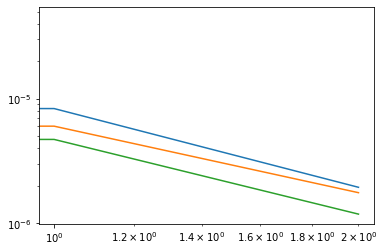

In [35]:
for l in range(lmax+1):
    plt.loglog(opt_eva[l])

Create compressed features, using labels naming consistent with Nigam 2020

In [36]:
sel_thresh = 1.5e-6
blocks = []
for l in range(lmax+1):
    n_selected = len(np.where(opt_eva[l] > sel_thresh)[0])    
    de_block = density_expansion.block(center_species = 6, neighbor_species=1, spherical_harmonics_l = l)
    block = Block(
        data = de_block.values@opt_eve[l][:,:n_selected],
        samples = de_block.samples,
        components = Labels(["m"],np.asarray(range(-l,l+1), dtype=np.int32).reshape(-1,1)),
        features = Labels(["n"], np.asarray([[n] for n in range(n_selected)], dtype=np.int32))
    )
    if rascal_hypers["compute_gradients"]:
        de_grad = de_block.gradient("positions")
        block.add_gradient(
            name="positions",
            samples=de_grad[0],
            gradient=de_grad[1]@opt_eve[l][:,:n_selected],
        )
    blocks.append( block )

In [37]:
acdc_nu1 = Descriptor(sparse = Labels(names=["sigma", "lam", "nu"], 
                                      values=np.asarray([[ 1, l, 1] for l in range(rascal_hypers["max_angular"]+1)], dtype=np.int32)), 
                      blocks = blocks
                     )

In [38]:
# multiplicity of the features, stored as a descriptor array
acdc_full_nu1 = Descriptor(
    sparse = acdc_nu1.sparse,
    blocks = [
        Block(
            data = np.ones(shape=(1,1,len(acdc_nu1.block(s).features))),
            samples = Labels(["dummy"], np.zeros(shape=(1,1), dtype=np.int32)),
            components = Labels(["dummy"], np.zeros(shape=(1,1), dtype=np.int32)),
            features = acdc_nu1.block(s).features
        ) for s in acdc_nu1.sparse
    ]
)

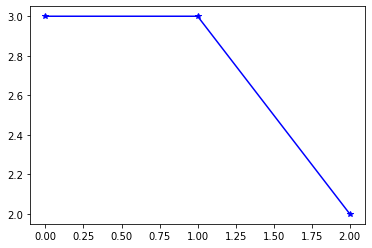

In [39]:
ln_nu1 = np.asarray([[s["lam"], b.values.shape[-1]] for s,b in acdc_nu1 ])
plt.plot(ln_nu1[:,0], ln_nu1[:,1], 'b*-')

# ACDC utilities

In [27]:
cg = ClebschGordanReal(lmax*3)

default (all to all)

In [40]:
acdc_nu2 = cg_increment(acdc_nu1, acdc_nu1, clebsch_gordan=cg)

specifying features

In [41]:
%%time
acdc_nu2 = cg_increment(acdc_nu1, acdc_nu1, acdc_full_nu1, acdc_full_nu1, clebsch_gordan=cg)
acdc_full_nu2 = full_product_indices(acdc_full_nu1, acdc_full_nu1)

CPU times: user 29.7 ms, sys: 143 µs, total: 29.8 ms
Wall time: 28.6 ms


In [42]:
%%time
acdc_nu3 = cg_increment(acdc_nu2, acdc_nu1, acdc_full_nu2, acdc_full_nu1, clebsch_gordan = cg)

CPU times: user 229 ms, sys: 4.32 ms, total: 233 ms
Wall time: 229 ms


## analyze jacobian

Requires `compute_gradients=True`

manually densify features

In [19]:
j_nu1 = []
for idx, block in acdc_nu1:
    smp, grad = block.gradient("positions")
    j_nu1.append(grad.reshape((grad.shape[0],-1)))
j_nu1 = np.concatenate(j_nu1, axis=-1).reshape(10,12,-1)    

In [20]:
j_nu2 = []
for idx, block in acdc_nu2:
    smp, grad = block.gradient("positions")
    j_nu2.append(grad.reshape((grad.shape[0],-1)))
j_nu2 = np.concatenate(j_nu2, axis=-1).reshape(10,12,-1)

In [21]:
j_nu3 = []
for idx, block in acdc_nu3:
    smp, grad = block.gradient("positions")
    j_nu3.append(grad.reshape((grad.shape[0],-1)))
j_nu3 = np.concatenate(j_nu3, axis=-1).reshape(10,12,-1)

sv_nu3 = np.asarray([ sp.linalg.svdvals(j_nu3[i])  for i in range(10)])

In [22]:
import scipy as sp

In [23]:
sv_nu1 = np.asarray([ sp.linalg.svdvals(j_nu1[i])  for i in range(10)])
sv_nu2 = np.asarray([ sp.linalg.svdvals(j_nu2[i])  for i in range(10)])

Text(0, 0.5, 'CN ($\\nu=2)$')

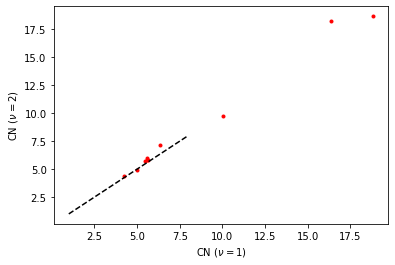

In [24]:
plt.plot(
    sv_nu1[:,0]/sv_nu1[:,-1],
    sv_nu2[:,0]/sv_nu2[:,-1],
    'r.'
)
plt.plot([1,8],[1,8],'k--')
plt.xlabel(r"CN ($\nu=1)$")
plt.ylabel(r"CN ($\nu=2)$")

Text(0, 0.5, 'CN ($\\nu=3)$')

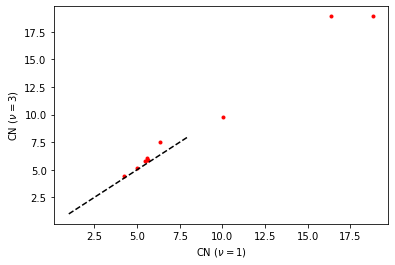

In [25]:
plt.plot(
    sv_nu1[:,0]/sv_nu1[:,-1],
    sv_nu3[:,0]/sv_nu3[:,-1],
    'r.'
)
plt.plot([1,8],[1,8],'k--')
plt.xlabel(r"CN ($\nu=1)$")
plt.ylabel(r"CN ($\nu=3)$")

# Independent feature tracking

This performs the cg iteration while avoiding to compute duplicate / linearly dependent features, and tracks the multiplicity so that no density (correlation) is lost

In [43]:
cg = ClebschGordanReal(lmax*5)

In [44]:
norm_full1 = features_norm(acdc_nu1)

In [45]:
acdc_sel_nu2 = canonical_indices(acdc_full_nu1, acdc_full_nu1)

In [46]:
%%time
canonical_acdc_nu2 = cg_increment(acdc_nu1, acdc_nu1, acdc_full_nu1, acdc_full_nu1, clebsch_gordan=cg, M=acdc_sel_nu2)

CPU times: user 21.3 ms, sys: 677 µs, total: 22 ms
Wall time: 20.9 ms


In [47]:
acdc_sel_nu3 = canonical_indices(acdc_sel_nu2, acdc_full_nu1)

In [48]:
%%time
canonical_acdc_nu3 = cg_increment(canonical_acdc_nu2, acdc_nu1, acdc_sel_nu2, acdc_full_nu1, clebsch_gordan=cg, 
                                    M=acdc_sel_nu3)

CPU times: user 146 ms, sys: 997 µs, total: 147 ms
Wall time: 144 ms


In [49]:
acdc_sel_nu4 = canonical_indices(acdc_sel_nu3, acdc_full_nu1)

In [50]:
%%time
canonical_acdc_nu4 = cg_increment(canonical_acdc_nu3, acdc_nu1, acdc_sel_nu3, acdc_full_nu1, clebsch_gordan=cg, 
                                    M=acdc_sel_nu4)

In [52]:
acdc_sel_nu5 = canonical_indices(acdc_sel_nu4, acdc_full_nu1)

In [53]:
%%time
canonical_acdc_nu5 = cg_increment(canonical_acdc_nu4, acdc_nu1, acdc_sel_nu4, acdc_full_nu1, clebsch_gordan=cg, 
                                    M=acdc_sel_nu5)

compute norms and show that they match the norm of nu=1 features to the power nu

In [59]:
nnu2_full = features_count(acdc_nu2)
nnu2_can = features_count(canonical_acdc_nu2)
norm_full2 = features_norm(acdc_nu2)
norm_can2 = features_norm(canonical_acdc_nu2)

In [58]:
print((nnu2_full, norm_full2.sum()), (nnu2_can, norm_can2.sum()), (norm_full1**2).sum())

(122, 3.873834622434604e-06) (72, 3.873834622434604e-06) 3.873834622434606e-06


In [60]:
nnu3_full = features_count(acdc_nu3)
nnu3_can = features_count(canonical_acdc_nu3)
norm_full3 = features_norm(acdc_nu3)
norm_can3 = features_norm(canonical_acdc_nu3)

In [61]:
print((nnu3_full, norm_full3.sum()), (nnu3_can, norm_can3.sum()),(norm_full1**3).sum())

(2204, 9.607837605262185e-10) (564, 9.60783760526219e-10) 9.607837605262195e-10


In [63]:
nnu4_can = features_count(canonical_acdc_nu4)
norm_can4 = features_norm(canonical_acdc_nu4)

In [64]:
print((nnu4_can, norm_can4.sum()),(norm_full1**4).sum())

(4020, 2.6749188416148777e-13) 2.6749188416148813e-13


In [65]:
nnu5_can = features_count(canonical_acdc_nu5)
norm_can5 = features_norm(canonical_acdc_nu5)

In [66]:
print((nnu5_can, norm_can5.sum()),(norm_full1**5).sum())

(26568, 8.126066561228681e-17) 8.126066561228692e-17


# Iterative scheme

In [69]:
acdc_thresh_nu2, thrnorm_nu2 = threshold_indices(acdc_nu1, acdc_nu1, acdc_full_nu1, acdc_full_nu1, 
                                                      sel_threshold=1e-9, l_threshold=6)

In [71]:
acdc_thresh_nu2, thrnorm_nu2 = threshold_indices(acdc_nu1, acdc_nu1, sel_threshold=1e-9, l_threshold=6)

In [72]:
acdc_thr_nu2 = cg_increment(acdc_nu1, acdc_nu1, acdc_full_nu1, acdc_full_nu1, M=acdc_thresh_nu2, clebsch_gordan=cg)

In [78]:
norm_thr2 = features_norm(acdc_thr_nu2)
nnu2_thr = features_count(acdc_thr_nu2)

In [79]:
print( norm_thr2.mean(), norm_thr2.mean()+thrnorm_nu2, norm_full2.mean())

2.1906593319806843e-08 3.8738346224346043e-08 3.873834622434604e-08


In [80]:
print(nnu2_full, nnu2_can, nnu2_thr)

122 72 26


In [90]:
acdc_zip_nu2, acdc_w_nu2 = compress_features(acdc_thr_nu2, 1e-9)

(1, 0, 2) [[ 1.00000000e+00 -5.32221760e-16  7.04812949e-17 -5.04783335e-17]
 [-5.32221760e-16  1.00000000e+00 -4.69162583e-17  2.29021361e-16]
 [ 7.04812949e-17 -4.69162583e-17  1.00000000e+00  2.74493586e-17]
 [-5.04783335e-17  2.29021361e-16  2.74493586e-17  1.00000000e+00]]
 empty selection (-1, 1, 2)
(1, 1, 2) [[2.0000000e+00 1.4484941e-16]
 [1.4484941e-16 2.0000000e+00]]
(-1, 2, 2) [[2.]]
(1, 2, 2) [[ 2.00000000e+00 -4.96564595e-16 -7.87564458e-16  6.59194921e-17
   3.67761377e-16]
 [-4.96564595e-16  1.00000000e+00  6.62664368e-16 -5.55111512e-17
   2.14238349e-16]
 [-7.87564458e-16  6.62664368e-16  2.00000000e+00  1.18568350e-15
   6.07993473e-16]
 [ 6.59194921e-17 -5.55111512e-17  1.18568350e-15  1.00000000e+00
  -3.29597460e-17]
 [ 3.67761377e-16  2.14238349e-16  6.07993473e-16 -3.29597460e-17
   1.00000000e+00]]
 empty selection (-1, 3, 2)
(1, 3, 2) [[2.]]
(1, 4, 2) [[ 1.00000000e+00 -4.25007252e-17]
 [-4.25007252e-17  1.00000000e+00]]


In [92]:
norm_zip2 = features_norm(acdc_zip_nu2)
nnu2_zip = features_count(acdc_zip_nu2)

In [93]:
print(norm_zip2.mean(), norm_thr2.mean(), norm_full2.mean())
print(nnu2_full, nnu2_can, nnu2_thr, nnu2_zip)

2.1906593319806833e-08 2.1906593319806843e-08 3.873834622434604e-08
122 72 26 15


## zipo New heading

recompute the compressed features!

In [97]:
acdc_zip_post_nu2 = cg_increment(acdc_nu1, acdc_nu1,  M=acdc_w_nu2, clebsch_gordan=cg)

In [99]:
features_norm(acdc_zip_post_nu2).mean()

2.1906593319806833e-08

In [101]:
features_norm(acdc_zip_nu2).mean()

2.1906593319806833e-08

In [409]:
acdc_thresh_nu3, thrnorm_nu3 = acdc_threshold_indices(acdc_zip_nu2, acdc_nu1, sel_threshold=1e-15, l_threshold=6)

In [433]:
acdc_nu1.block(1).values.shape

(100, 3, 4)

In [432]:
acdc_zip_nu2.block(1).values.shape

(100, 3, 4)

In [416]:
acdc_full_nu1.block(0).values.shape

(1, 1, 4)

In [434]:
acdc_thr_nu3 = acdc_increment(acdc_zip_nu2, acdc_nu1, M=acdc_thresh_nu3)

prep 2.2820067405700684
calc 0.6412680149078369
clean 0.03527641296386719


In [334]:
acdc_features_norm(acdc_zipx_nu2).mean()

8.039059317539691e-08

In [47]:
X = acdc_nu2.block(0).values

In [108]:
rX = X.reshape(-1,X.shape[-1]) * 1
lsel = []
bm_idx = np.arange(rX.shape[1])

In [160]:
nrm = (rX**2).sum(axis=0)
sel_idx = nrm.argmax()
sel_x = rX[:,sel_idx]/np.sqrt(nrm[sel_idx])
lsel.append(bm_idx[sel_idx])
bm_idx = np.concatenate([bm_idx[:sel_idx], bm_idx[sel_idx+1:]])
print(sel_idx, nrm[sel_idx], nrm.sum())

27 2.3892448658543675e-09 3.122281850927408e-08


In [161]:
nrm

array([1.11062808e-39, 6.93504988e-10, 3.13232110e-39, 2.48041981e-42,
       5.31008445e-10, 2.12874581e-40, 6.93504988e-10, 5.31008445e-10,
       3.96449913e-10, 3.77473965e-40, 1.76060989e-09, 5.39873981e-10,
       2.23349821e-09, 4.63488518e-10, 1.76060989e-09, 2.23349821e-09,
       1.86380508e-09, 4.60106804e-10, 5.39873981e-10, 4.63488518e-10,
       4.60106804e-10, 5.39874065e-10, 5.10551414e-40, 1.52601900e-09,
       1.83467279e-40, 1.52601900e-09, 1.43768252e-09, 2.38924487e-09,
       1.16466699e-09, 2.38924487e-09, 1.22722377e-09, 1.16466699e-09,
       1.22722377e-09, 1.00651602e-09])

In [162]:
prj = sel_x.reshape(-1,1) @( sel_x@rX).reshape(1,-1)
rX -= prj
rX = np.hstack([rX[:,:sel_idx], rX[:,sel_idx+1:]])

In [163]:
lsel

[0, 1, 2, 16, 41, 32, 21, 5, 3, 36, 10, 35, 45, 20, 6, 34, 42]

In [164]:
xsel = X.reshape(-1,X.shape[-1])[:,lsel]

In [166]:
(X.squeeze()@X.squeeze().T - xsel@xsel.T ).diagonal().sum()

2.2712629660270754e-07

In [65]:
nrm

array([2.42940970e-07, 2.46073523e-08, 1.03791992e-08, 4.45236273e-08,
       2.29396324e-08, 7.32309093e-09, 3.56362288e-09, 2.46073523e-08,
       7.32309093e-09, 9.12791720e-09, 1.38798002e-09, 1.03791992e-08,
       3.56362288e-09, 1.38798002e-09, 1.52720383e-09, 6.08419466e-08,
       1.12379404e-08, 5.15856091e-09, 1.39895330e-09, 1.12379404e-08,
       3.10903465e-08, 6.50486933e-09, 1.88331929e-09, 5.15856091e-09,
       6.50486933e-09, 1.33623268e-08, 3.27955986e-09, 1.39895330e-09,
       1.88331929e-09, 3.27955986e-09, 3.30279380e-09, 5.33147404e-08,
       8.50633090e-09, 4.30948222e-09, 8.50633090e-09, 3.52817376e-08,
       7.90600428e-09, 4.30948222e-09, 7.90600428e-09, 9.88785826e-09,
       7.96731127e-08, 8.35800052e-09, 3.48786496e-09, 8.35800052e-09,
       2.28591699e-08, 2.75720216e-09, 3.48786496e-09, 2.75720216e-09,
       5.14521614e-09])

In [169]:
aa = np.linalg.pinv(xsel)@X.squeeze()

In [170]:
aa.shape

(17, 50)

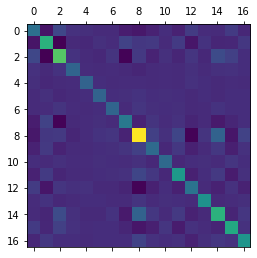

In [175]:
plt.matshow(aa@aa.T)

In [182]:
sa2 = sp.linalg.sqrtm(aa@aa.T)

In [183]:
a = sa2.diagonal()

In [184]:
a

array([1.11536385, 1.64163874, 1.78709715, 1.02243073, 1.01791862,
       1.0182443 , 1.02395343, 1.19304515, 2.1495854 , 1.07445593,
       1.07917565, 1.48931755, 1.14297522, 1.44629773, 1.64643365,
       1.60891811, 1.45764279])

In [185]:
(X.squeeze()@X.squeeze().T - xsel@(aa@aa.T)@xsel.T ).diagonal().sum()

2.6099012899812683e-08

In [186]:
(X.squeeze()@X.squeeze().T - xsel@np.diag(a**2)@xsel.T ).diagonal().sum()

-8.337245205201047e-08